# Seminar-7: Time-To-Speech

Text-to-speech (TTS) is the task of creating natural-sounding speech from text, where the speech can be generated in multiple languages and for multiple speakers. Several text-to-speech models are currently avaliable in Transformers, such as Bark, MMS, VITS and SpeechT5. We can easily generate audio using the `text-to-audio` pipeline (or its alias `text-to-speech`). Som models, like Bark, can also be conditioned to generate non-verbal communications such as laughing, and crying, or even add music.


Based on [Fine-tuning SpeechT5](https://huggingface.co/learn/audio-course/en/chapter6/fine-tuning)

## Speech-To-Text
1. What loss function do we use?
1. What special tokens should we add to the sequence of input tokens?

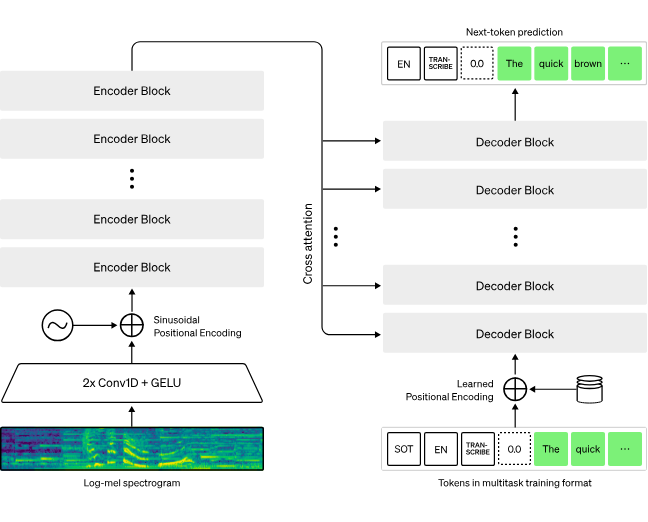

## Text-To-Speech
1. What loss function do we use?
1. What else besides the mel-pectrogram should we predict?

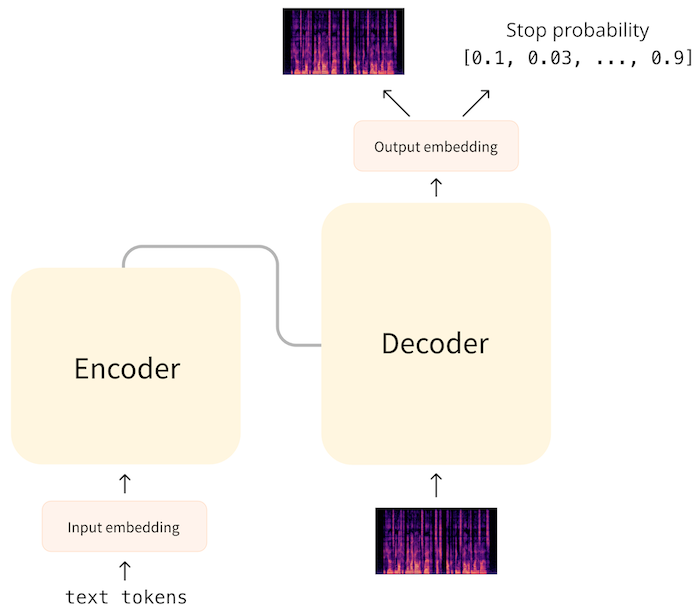

In [ ]:
%%capture
!pip install transformers==4.35.2
!pip install datasets==2.15.0
!pip install soundfile==0.12.1
!pip install speechbrain==0.5.16

In [76]:
from transformers import pipeline

# example of pipelien text-to-speech

pipe=pipeline("text-to-speech", model="suno/bark-small", device='cuda')
text="[clears throat] This is a test ...  and I just took a long pause."
output=pipe(text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

In [77]:
from IPython.display import Audio

Audio(output["audio"], rate=output["sampling_rate"])

We are goging to fine-tune a TTS model, we can currently fine-tune SpeechT5. It is pre-trained on a combination of `speech-to-text` and `text-to-speech` data, allowing it to learn a unified space of hidden representations shared by both text and speech. This means that the same pre-trained model can be fine-tuned for different tasks. Furthermore, SpeechT5 supports multiple speakers through x-vector speaker embeddings.

In [78]:
import os
from huggingface_hub import login

login(token=token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Loading the dataset

Here we are going to use `MultiLingual LibriSpeech` dataset. It is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages.

**Note that automated speech recognition(ASR) dataset may not be the most suitable option for training TTS models. The features that make it beneficial for ASR, such as excessive background noise, are typically undesirable in TTS. However, finding top-quality, multilingual, and multi-speaker TTS datasets can be quite challenging.**

In [74]:
from datasets import load_dataset, Audio

mls = load_dataset("facebook/multilingual_librispeech", "german", split="train")
mls

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/63 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Dataset({
    features: ['audio', 'original_path', 'begin_time', 'end_time', 'transcript', 'audio_duration', 'speaker_id', 'chapter_id', 'file', 'id'],
    num_rows: 469942
})

SpeechT5 expects audio data to have a sampling rate of 16 kHz, so make sure the examples in the dataset meet this requirement.

In [75]:
dataset=mls.cast_column("audio", Audio(sampling_rate=16000))

# Preprocess the data
Let's begin by defining the model checkpoint to use and loading the appropriate processor:

In [79]:
from transformers import SpeechT5Processor

checkpoint="microsoft/speecht5_tts"
processor=SpeechT5Processor.from_pretrained(checkpoint)

In [80]:
?? processor

# Text cleanup for SpeechT5 tokenization

The dataset examples contain `transcript` feature. When deciding which feature to use as the text input, consider that the SpeechT5 tokenizer doesn't have any tokens for numbers. For a better fit we recommend using normalized text as input text. The text in the `transcript` field is already normalized.

Because SpeechT5 was trained on the English language, it may not recognize certrain characters in the German dataset. If left as is, these characters will be converted to `<unk>` tokens. However, in German, certain characters like `ä` are used to stress syllables. In order to preserve the meaning of the text, we can replace this character with a regular `a`.

To identify `unsupported` tokens, extract all unique characters in the dataset using the SpeechT5 Tokenizer which works with chatacters as tokens. To do this, write the `extract_all_chars` mapping function that concatenates the transcriptions from all examples into one string and converts it to a set of characters. Make sure to set batched=True and batch_size=-1 in dataset.map() so that all transcriptions are avaliable at once for the mapping function.

In [82]:
def extract_all_chars(batch):
    all_text=" ".join(batch["transcript"]) # normalized_text
    vocab=list(set(all_text))
    return {"vocab": [vocab], "all_text":[all_text]}

vocabs=dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)


tokenizer=processor.tokenizer

dataset_vocab=set(vocabs["vocab"][0])
tokenizer_vocab={k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/469942 [00:00<?, ? examples/s]

# Deal with Special Characters

Now, we have two sets of characters: one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. To identify any unsupported characters in the dataset, we can take the difference between these two sets. The resulting set will contain the characters that are in the dataset but not in the tokenizer.

To handle the unsupported characters identified in the previous step, define a function that maps these characters to valid tokens. Note that spaces are already replaced by _ in the tokenizer and do not need to be handled separately.

In [83]:
print(dataset_vocab - tokenizer_vocab)

replacements=[
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
    ("ä", "a"),
    ("ß", "ss"),
    ("ö", "o"),
    ("ü", "u")
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["transcript"]=inputs["transcript"].replace(src, dst)
    return inputs

dataset=dataset.map(cleanup_text)

{'ä', ' ', 'ß', 'ö', 'ü'}


Now that we have deal with special characters in the text, it's time to shift focus to the audio data.

# Checking Speakers

The MultiLingual LibriSpeech dataset includes speech from multiple speakers, but how many speakers are represented in the datasets? To determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset. With a total of 469942 examples in the dataset, this information will give us a better understanding of the distribution of speakers and examples in the data.

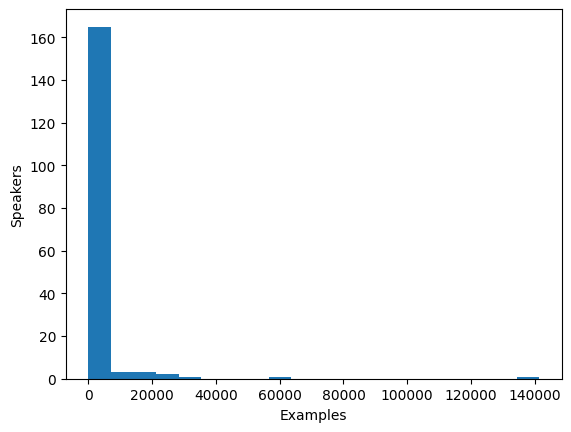

In [85]:
from collections import defaultdict
import matplotlib.pyplot as plt

speaker_counts=defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id]+=1

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

# Cleaning Data

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while arounf ten speakers have more than 500 examples. To improve training effficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

Note that some speakers with few examples may actually have more audio available if the examples are long. However, determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

In [86]:
def select_speaker(speaker_id):
    return 100<=speaker_counts[speaker_id]<=400 # change it for better fit

dataset=dataset.filter(select_speaker, input_columns=["speaker_id"])

# Let's check how many speakers remain
print(len(set(dataset["speaker_id"])))

# Let's see how many examples are left
print(len(dataset))

12
3432


# Speaker embeddings

To enable the TTS model to differentiable between multiple speakers, we will need to create a speaker emebeddings for each example. The speaker embedding it an additional input into the model that captures a particular speaker's voice characteristics. To generate these speakers embeddings, use the pre-trained spkrec-xvect-voxceleb model from SpeechBrain. Create a function **create_speaker_emebdding()** that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding. It's important to note that the speechbrain/spkrec-xvect-voxceleb model was trained on **English** speech from the **VoxCeleb** dataset, whereas the training examples in here are in **German**. While we believe that this model will still generate reasonable speaker embeddings for our German dataset, this assumption may not hold true in all cases.

For optimal results, we recommend training an X-vector model on the target speech first. This will ensure that the model is better able to capture the unique voice characteristics present in the German language.

In [87]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name="speechbrain/spkrec-xvect-voxceleb"

device="cuda"
speaker_model=EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings=speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings=torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings=speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings


def prepare_dataset(example):
    audio=example["audio"]

    example=processor(
        text=example["transcript"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off thje batch dimension
    example["labels"]=example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"]=create_speaker_embedding(audio["array"])

    return example

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(path, map_location=device), strict=Fal

Verify the processing is correct by looking at a single example, the speaker embeddings should be a 512-element vector, and the labels should be a log-mel spectrogram with 80 mel bins.

['input_ids', 'labels', 'speaker_embeddings']
(512,)


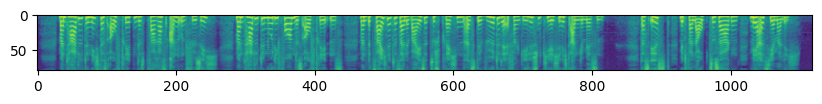

In [89]:
import matplotlib.pyplot as plt


processed_example=prepare_dataset(dataset[0])
print(list(processed_example.keys()))
print(processed_example["speaker_embeddings"].shape)

plt.figure(figsize=(10, 30))
plt.imshow(processed_example["labels"].T)
plt.show()

In [90]:
dataset

Dataset({
    features: ['audio', 'original_path', 'begin_time', 'end_time', 'transcript', 'audio_duration', 'speaker_id', 'chapter_id', 'file', 'id'],
    num_rows: 3432
})

In [91]:
# applying the processing function to the entire dataset
dataset=dataset.map(prepare_dataset, remove_columns=dataset.column_names)

We will see a warning saying that some examples in the dataset are longer than the maximum input length the model can handle(600 tokens). Remove those examples from the dataset. Here we go even further and to follow for larger batch sizes we remove anything over 200 tokens.

In [92]:
def is_not_too_long(input_ids):
    input_length=len(input_ids)
    return input_length<200

dataset=dataset.filter(is_not_too_long, input_columns=["input_ids"])

In [93]:
dataset=dataset.train_test_split(test_size=0.1)

In [94]:
dataset['test']

Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 125
})

In [ ]:
dataset.save_to_disk('./dataset')

Saving the dataset (0/1 shards):   0%|          | 0/1117 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/125 [00:00<?, ? examples/s]

In [ ]:
# import shutil

# dataset.save_to_disk('./dataset')
# shutil.copytree('./dataset', '/content/drive/MyDrive/seminar_tts/dataset')

In [ ]:
from datasets import load_from_disk
dataset = load_from_disk(f'./{dataset_dir}')

In [ ]:
dataset

## Data collator

We want to combine multiple examples into a batch, we need to define a custom data collator. This collator will pad shorter sequences with padding tokens, ensuring that all examples have the same length. For the spectrogram labels, the padded portions are replaced with the special value `-100`. This special value instructs the model to ignore that part of the spectrogram when calculating the spectrogram loss.

In [95]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:

    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids=[{"input_ids":feature["input_ids"]} for feature in features]
        label_features=[{"input_values":feature["labels"]} for feature in features]
        speaker_features=[feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch=processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"]=batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1),-100)

        #not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor>1:
            target_lengths=torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths=target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length=max(target_lengths)
            batch["labels"]=batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"]=torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [96]:
data_collator=TTSDataCollatorWithPadding(processor=processor)

# Train the model

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training.

In [97]:
from transformers import SpeechT5ForTextToSpeech

model=SpeechT5ForTextToSpeech.from_pretrained(checkpoint)
model.config.use_cache=False
print(model.config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

SpeechT5Config {
  "_name_or_path": "microsoft/speecht5_tts",
  "activation_dropout": 0.1,
  "apply_spec_augment": true,
  "architectures": [
    "SpeechT5ForTextToSpeech"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 12,
  "encoder_max_relative_position": 160,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_norm": "group",
  "feat_proj_dropout": 0.0,
  "guided_attention_loss_num_heads": 2,
  "guided_attention_loss_scale": 10.0,
  "guided_attention_loss_sigma": 

In [98]:
model

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

In [99]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args=Seq2SeqTrainingArguments(
    output_dir="./model",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=100,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=50,
    eval_steps=50,
    logging_steps=25,
    report_to="tensorboard",
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

trainer=Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior,

Step,Training Loss,Validation Loss
50,0.637400,0.543502
100,0.576100,0.514598


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


TrainOutput(global_step=100, training_loss=0.6335579872131347, metrics={'train_runtime': 417.7923, 'train_samples_per_second': 7.659, 'train_steps_per_second': 0.239, 'total_flos': 518984296674624.0, 'train_loss': 0.6335579872131347, 'epoch': 2.86})

In [100]:
trainer.evaluate()

{'eval_loss': 0.5141732692718506,
 'eval_runtime': 8.9641,
 'eval_samples_per_second': 13.945,
 'eval_steps_per_second': 7.028,
 'epoch': 2.86}

# Inference

In [101]:
from transformers import pipeline

pipe=pipeline("text-to-speech", model="./model/checkpoint-100", device='cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will 

In [107]:
text="Straße"


speaker_embeddings = torch.tensor(dataset['test'][120]['speaker_embeddings']).unsqueeze(0)
forward_params={"speaker_embeddings": speaker_embeddings}
output=pipe(text, forward_params=forward_params)

In [108]:
from IPython.display import Audio
Audio(output['audio'], rate=output['sampling_rate'])